# Modelling Surface Energy Balance at an AmeriFlux Site Using SuPy

This tutorial aims to demonstrate how to use an advanced land surface model (SuPy, SUEWS in Python) to better understand the surface energy balance (SEB) features by conducting simulation at an AmeriFlux site. This would be particularly useful after building your own model: as you will learn how sophisticated models could be developed from those simpler ones.



[SuPy](https://supy.readthedocs.io/) is a Python-enhanced urban climate model with [SUEWS, *Surface Urban Energy and Water Balance Scheme*](https://suews.readthedocs.io/), as its computation core.
More SuPy tutorials are available [here](https://supy.readthedocs.io/en/latest/tutorial/tutorial.html).

In this tutorial the workflow to model the surface energy balance (SEB) at a chosen AmeriFlux (AMF) site using SuPy/SUEWS is undertaken. The steps, consist of


1. [Preparing the input data](#Prepare-input-data);
2. [Running a simulation](#Run-simulations);
3. [Examination of results](#Examine-results); and
4. [Further exploration](#More-explorations-into-simulation-results)





Before starting, you need to install SuPy and load the following necessary packages.

```
pip install supy==2019.11.18.dev0

```



In [1]:
# !pip install supy==2019.11.18.dev0 &> install.log

In [2]:
import matplotlib.pyplot as plt
import supy as sp
import pandas as pd
import numpy as np
from pathlib import Path
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sp.show_version()

supy: 2019.11.18dev
supy_driver: 2019a18


## Prepare input data

### Overview of SuPy input 

#### Load sample data:


To ease the preparation of model input, a helper function `load_SampleData` is provided to get the sample input for SuPy simulations, which will later be used as template to populate your specific model configurations and forcing input.

In [5]:
df_state_init, df_forcing = sp.load_SampleData()

2019-11-22 09:16:28,573 — SuPy — INFO — All cache cleared.


#### `df_state_init`

`df_state_init` includes model Initial state consisting of:

* surface characteristics (e.g., albedo, emissivity, land cover fractions, etc.; full details refer to [SUEWS documentation](https://suews-docs.readthedocs.io/en/latest/input_files/SUEWS_SiteInfo/SUEWS_SiteInfo.html)).

* model configurations (e.g., stability; full details refer to [SUEWS documentation](https://suews-docs.readthedocs.io/en/latest/input_files/RunControl/RunControl.html)).

Detailed description of variables in `df_state_init` refers to [SuPy input](../data-structure/supy-io.ipynb#df_state_init:-model-initial-states).

- Surface land cover fraction information in the sample input dataset:

In [6]:
df_state_init.filter(like='sfr')

var       sfr                                        
ind_dim  (0,)  (1,)   (2,)   (3,)   (4,)   (5,)  (6,)
grid                                                 
98       0.43  0.38  0.001  0.019  0.029  0.001  0.14

- Heights of bluff-bodies (m):

In [7]:
df_state_init.loc[:, ['bldgh', 'evetreeh', 'dectreeh']]

var,bldgh,dectreeh,evetreeh
ind_dim,0,0,0
grid,,,
98,22.0,13.1,13.1


#### `df_forcing`

`df_forcing` includes meteorological and other external forcing information.

Detailed description of variables in `df_forcing` refers to [SuPy input](../data-structure/supy-io.ipynb#df_forcing:-forcing-data).

Below is a view of heading lines of the forcing variables.

In [8]:
df_forcing.head()

,iy,id,it,imin,qn,qh,qe,qs,qf,U,...,snow,ldown,fcld,Wuh,xsmd,lai,kdiff,kdir,wdir,isec
2012-01-01 00:05:00,2012,1,0,5,-999.0,-999.0,-999.0,-999.0,-999.0,4.5225,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0
2012-01-01 00:10:00,2012,1,0,10,-999.0,-999.0,-999.0,-999.0,-999.0,4.5225,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0
2012-01-01 00:15:00,2012,1,0,15,-999.0,-999.0,-999.0,-999.0,-999.0,4.5225,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0
2012-01-01 00:20:00,2012,1,0,20,-999.0,-999.0,-999.0,-999.0,-999.0,4.5225,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0
2012-01-01 00:25:00,2012,1,0,25,-999.0,-999.0,-999.0,-999.0,-999.0,4.5225,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0


### Site-specific configuration of surface parameters

Given `pandas.DataFrame` as the core data structure of SuPy, all operations, including modification, output, demonstration, etc., on SuPy inputs (`df_state_init` and `df_forcing`) can be done using `pandas`-based functions/methods.
Please see [SuPy quickstart](https://supy.readthedocs.io/en/latest/tutorial/quick-start.html#Modification-of-SuPy-input) for methods to do so.

Below we will modify several key properties of the chosen site with appropriate values to run SuPy.
First, we copy the `df_state_init` to have a new DataFrame for manipulation.

In [9]:
df_state_amf = df_state_init.copy()

In [10]:
# site identifier
name_site = 'US-AR1'

#### location

In [11]:
# latitude
df_state_amf.loc[:, 'lat'] = 41.37
# longitude
df_state_amf.loc[:, 'lng'] = -106.24
# altitude
df_state_amf.loc[:, 'alt'] = 611.

#### land cover fraction

[Land covers in SUEWS](https://suews.readthedocs.io/en/latest/introduction.html)

In [12]:
# view the surface fraction variable: `sfr`
df_state_amf.loc[:, 'sfr'] = 0
df_state_amf.loc[:, ('sfr', '(4,)')] = 1
df_state_amf.loc[:, 'sfr']

ind_dim,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)"
grid,,,,,,,
98,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### albedo

In [13]:
# we only set values for grass as the modelled site has a single land cover type: grass.
df_state_amf.albmax_grass = 0.19
df_state_amf.albmin_grass = 0.14

In [14]:
# initial albedo value
df_state_amf.loc[:, 'albgrass_id'] = 0.14

#### LAI/phenology

In [15]:
df_state_amf.filter(like='lai')

var     laimax           laimin           laipower                        ...  \
ind_dim   (0,) (1,) (2,)   (0,) (1,) (2,)   (0, 0) (0, 1) (0, 2)  (1, 0)  ...   
grid                                                                      ...   
98         5.1  5.5  5.9    4.0  1.0  1.6     0.03   0.03   0.03  0.0005  ...   

var                             laitype           laicalcyes lai_id            
ind_dim  (3, 0)  (3, 1)  (3, 2)    (0,) (1,) (2,)          0   (0,) (1,) (2,)  
grid                                                                           
98       0.0005  0.0005  0.0005     0.0  0.0  0.0          1    4.0  1.0  1.6  

[1 rows x 25 columns]

In [16]:
# properties to control vegetation phenology
# you can skip the details for and just set them as provided below

# LAI paramters
df_state_amf.loc[:, ('laimax', '(2,)')] = 1
df_state_amf.loc[:, ('laimin', '(2,)')] = 0.2
# initial LAI
df_state_amf.loc[:, ('lai_id', '(2,)')] = 0.2

# BaseT
df_state_amf.loc[:, ('baset', '(2,)')] = 5
# BaseTe
df_state_amf.loc[:, ('basete', '(2,)')] = 20

# SDDFull
df_state_amf.loc[:, ('sddfull', '(2,)')] = -1000
# GDDFull
df_state_amf.loc[:, ('gddfull', '(2,)')] = 1000

#### surface resistance

In [17]:
# parameters to model surface resistance
df_state_amf.maxconductance = 18.7
df_state_amf.g1 = 1
df_state_amf.g2 = 104.215
df_state_amf.g3 = 0.424
df_state_amf.g4 = 0.814
df_state_amf.g5 = 36.945
df_state_amf.g6 = 0.025

#### measurement height

In [18]:
# height where forcing variables are measured/collected
df_state_amf.z = 2.84

#### urban feature

In [19]:
# disable anthropogenic heat by setting zero population
df_state_amf.popdensdaytime = 0
df_state_amf.popdensnighttime = 0

#### check `df_state`

In [20]:
# this procedure is to double-check proper values are set in `df_state_amf`
sp.check_state(df_state_amf)

2019-11-22 09:16:30,954 — SuPy — INFO — SuPy is validating `df_state`...
2019-11-22 09:16:31,120 — SuPy — INFO — All checks for `df_state` passed!


### prepare forcing conditions

Here we use the a SuPy utility function `read_forcing` to read in forcing data from an external file in the format of SUEWS input.
Also note, this `read_forcing` utility will also resample the forcing data to a proper temporal resolution to run SuPy/SUEWS, which is usually 5 min (300 s).

#### load and resample forcing data

In [21]:
# load forcing data from an external file and resample to a resolution of 300 s.
# Note this dataset has been gap-filled.
df_forcing_amf = sp.util.read_forcing('./data/US-AR1_2010_data_60.txt',
                                      tstep_mod=300)

# this procedure is to double-check proper forcing values are set in `df_forcing_amf`
_ = sp.check_forcing(df_forcing_amf)

2019-11-22 09:16:32,059 — SuPy — INFO — SuPy is validating `df_forcing`...
2019-11-22 09:16:34,374 — SuPy — ERROR — Issues found in `df_forcing`:
`kdown` should be between [0, 1400] but `-1.3057500000000002` is found at 2010-01-01 00:05:00


The checker detected invalid values in variable `kdown`: negative incoming solar radiation is found. We then need to fix this as follows:

In [22]:
# modify invalid values
df_forcing_amf.kdown = df_forcing_amf.kdown.where(df_forcing_amf.kdown > 0, 0)

In [23]:
# check `df_forcing` again
_ = sp.check_forcing(df_forcing_amf)

2019-11-22 09:16:34,466 — SuPy — INFO — SuPy is validating `df_forcing`...
2019-11-22 09:16:36,946 — SuPy — INFO — All checks for `df_forcing` passed!


#### examine forcing data

We can examine the forcing data:

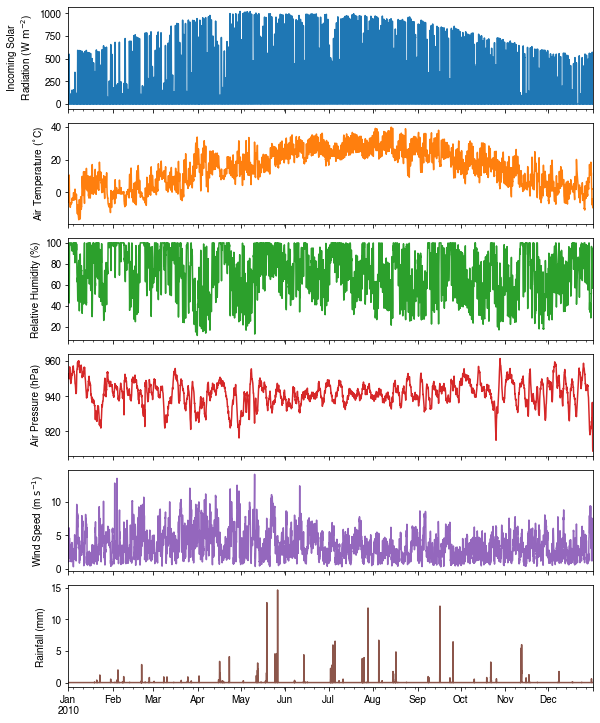

In [24]:
list_var_forcing = [
    'kdown',
    'Tair',
    'RH',
    'pres',
    'U',
    'rain',
]
dict_var_label = {
    'kdown': 'Incoming Solar\n Radiation ($ \mathrm{W \ m^{-2}}$)',
    'Tair': 'Air Temperature ($^{\circ}}$C)',
    'RH': r'Relative Humidity (%)',
    'pres': 'Air Pressure (hPa)',
    'rain': 'Rainfall (mm)',
    'U': 'Wind Speed (m $\mathrm{s^{-1}}$)'
}
df_plot_forcing_x = df_forcing_amf.loc[:, list_var_forcing].copy().shift(
    -1).dropna(how='any')
df_plot_forcing = df_plot_forcing_x.resample('1h').mean()
df_plot_forcing['rain'] = df_plot_forcing_x['rain'].resample('1h').sum()

axes = df_plot_forcing.plot(
    subplots=True,
    figsize=(8, 12),
    legend=False,
)
fig = axes[0].figure
fig.tight_layout()
fig.autofmt_xdate(bottom=0.2, rotation=0, ha='center')
for ax, var in zip(axes, list_var_forcing):
    _ = ax.set_ylabel(dict_var_label[var])

## Run simulations

Once met-forcing (via `df_forcing_amf`) and initial conditions (via `df_state_amf`) are loaded in, we call `sp.run_supy` to conduct a SUEWS simulation, which will return two `pandas` `DataFrame`s: `df_output` and `df_state_final`.

In [25]:
df_output, df_state_final = sp.run_supy(df_forcing_amf, df_state_amf)

2019-11-22 09:16:40,809 — SuPy — INFO — ====================
2019-11-22 09:16:40,810 — SuPy — INFO — Simulation period:
2019-11-22 09:16:40,811 — SuPy — INFO —   Start: 2010-01-01 00:05:00
2019-11-22 09:16:40,811 — SuPy — INFO —   End: 2011-01-01 00:00:00
2019-11-22 09:16:40,812 — SuPy — INFO — 
2019-11-22 09:16:40,813 — SuPy — INFO — No. of grids: 1
2019-11-22 09:16:40,813 — SuPy — INFO — SuPy is running in serial mode
2019-11-22 09:16:54,304 — SuPy — INFO — Execution time: 13.5 s
2019-11-22 09:16:54,305 — SuPy — INFO — ====================



### `df_output`

`df_output` is an ensemble output collection of major SUEWS output groups, including:

* SUEWS: the essential SUEWS output variables
* DailyState: variables of daily state information
* snow: snow output variables (effective when `snowuse = 1` set in `df_state_init`)
* RSL: profile of air temperature, humidity and wind speed within roughness sub-layer.

Detailed description of variables in `df_output` refers to [SuPy output](../data-structure/supy-io.html#df_output:-model-output-results)

In [26]:
df_output.columns.levels[0]

Index(['SUEWS', 'snow', 'RSL', 'DailyState'], dtype='object', name='group')

### `df_state_final`

`df_state_final` is a `DataFrame` for holding:

1. all model states if `save_state` is set to `True` when calling `sp.run_supy` and `supy` may run significantly slower for a large simulation;
2. or, only the final state if `save_state` is set to `False` (the default setting) in which mode `supy` has a similar performance as the standalone compiled SUEWS executable.

Entries in `df_state_final` have the same data structure as `df_state_init` and can thus be used for other SUEWS simulations staring at the timestamp as in `df_state_final`.

Detailed description of variables in `df_state_final` refers to [SuPy output](../data-structure/supy-io.html#df_state_final:-model-final-states)

In [27]:
df_state_final.T.head()

datetime                 2010-01-01 00:05:00 2011-01-01 00:05:00
grid                                      98                  98
var              ind_dim                                        
ah_min           (0,)                   15.0                15.0
                 (1,)                   15.0                15.0
ah_slope_cooling (0,)                    2.7                 2.7
                 (1,)                    2.7                 2.7
ah_slope_heating (0,)                    2.7                 2.7

## Examine results

Thanks to the functionality inherited from `pandas` and other packages under the [PyData](https://pydata.org) stack, compared with the standard SUEWS simulation workflow, `supy` enables more convenient examination of SUEWS results by statistics calculation, resampling, plotting (and many more).

### Ouptut structure

`df_output` is organised with `MultiIndex` `(grid,timestamp)` and `(group,varaible)` as `index` and `columns`, respectively.

In [28]:
df_output.head()

group                    SUEWS                                         \
var                      Kdown  Kup       Ldown         Lup     Tsurf   
grid datetime                                                           
98   2010-01-01 00:05:00   0.0  0.0  265.638676  305.413842 -1.587667   
     2010-01-01 00:10:00   0.0  0.0  265.638676  305.413842 -1.587667   
     2010-01-01 00:15:00   0.0  0.0  265.638676  305.413842 -1.587667   
     2010-01-01 00:20:00   0.0  0.0  265.638676  305.413842 -1.587667   
     2010-01-01 00:25:00   0.0  0.0  265.638676  305.413842 -1.587667   

group                                                                     ...  \
var                              QN   QF         QS         QH        QE  ...   
grid datetime                                                             ...   
98   2010-01-01 00:05:00 -39.775166  0.0 -50.989269  11.054221  0.159883  ...   
     2010-01-01 00:10:00 -39.775166  0.0 -50.729902  10.795477  0.159259  ...   
     2010-01-01 00:15:00 -39.775166  0.0 -50.481342  10.547515  0.158661  ...   
     2010-01-01 00:20:00 -39.775166  0.0 -50.243138  10.309886  0.158086  ...   
     2010-01-01 00:25:00 -39.775166  0.0 -50.014860  10.082159  0.157534  ...   

group                        DailyState                                \
var                      DensSnow_Paved DensSnow_Bldgs DensSnow_EveTr   
grid datetime                                                           
98   2010-01-01 00:05:00            NaN            NaN            NaN   
     2010-01-01 00:10:00            NaN            NaN            NaN   
     2010-01-01 00:15:00            NaN            NaN            NaN   
     2010-01-01 00:20:00            NaN            NaN            NaN   
     2010-01-01 00:25:00            NaN            NaN            NaN   

group                                                                  \
var                      DensSnow_DecTr DensSnow_Grass DensSnow_BSoil   
grid datetime                                                           
98   2010-01-01 00:05:00            NaN            NaN            NaN   
     2010-01-01 00:10:00            NaN            NaN            NaN   
     2010-01-01 00:15:00            NaN            NaN            NaN   
     2010-01-01 00:20:00            NaN            NaN            NaN   
     2010-01-01 00:25:00            NaN            NaN            NaN   

group                                                
var                      DensSnow_Water  a1  a2  a3  
grid datetime                                        
98   2010-01-01 00:05:00            NaN NaN NaN NaN  
     2010-01-01 00:10:00            NaN NaN NaN NaN  
     2010-01-01 00:15:00            NaN NaN NaN NaN  
     2010-01-01 00:20:00            NaN NaN NaN NaN  
     2010-01-01 00:25:00            NaN NaN NaN NaN  

[5 rows x 345 columns]

Here we demonstrate several typical scenarios for SUEWS results examination.

The essential `SUEWS` output collection is extracted as a separate variable for easier processing in the following sections. More [advanced slicing techniques](http://pandas.pydata.org/pandas-docs/stable/advanced.html#multiindex-advanced-indexing) are available in `pandas` documentation.

In [29]:
grid = df_state_amf.index[0]
df_output_suews = df_output.loc[grid, 'SUEWS']

### Statistics Calculation

We can use `.describe()` method for a quick overview of the key surface energy balance budgets.

In [30]:
df_output_suews.loc[:, ['QN', 'QS', 'QH', 'QE', 'QF']].describe()

var,QN,QS,QH,QE,QF
count,105120.000000,105120.000000,105120.000000,105120.000000,105120.0
mean,118.291222,9.117453,53.611159,56.302547,0.0
std,213.150698,82.433076,72.044586,93.959856,0.0
min,-98.895138,-103.332153,-136.770097,-10.592811,0.0
25%,-32.252113,-46.922708,9.790903,0.633106,0.0
50%,-1.216564,-33.883630,25.756834,4.240341,0.0
75%,247.458581,55.231281,75.382465,67.207728,0.0
max,746.187700,262.700179,403.492712,445.496829,0.0


### Plotting

#### Basic example
Plotting is very straightforward via the `.plot` method bounded with `pandas.DataFrame`.
Note the usage of `loc` for to slices of the output `DataFrame`.

In [31]:
# a dict for better display variable names
dict_var_disp = {
    'QN': '$Q^*$',
    'QS': r'$\Delta Q_S$',
    'QE': '$Q_E$',
    'QH': '$Q_H$',
    'QF': '$Q_F$',
    'Kdown': r'$K_{\downarrow}$',
    'Kup': r'$K_{\uparrow}$',
    'Ldown': r'$L_{\downarrow}$',
    'Lup': r'$L_{\uparrow}$',
    'Rain': '$P$',
    'Irr': '$I$',
    'Evap': '$E$',
    'RO': '$R$',
    'TotCh': '$\Delta S$',
}

Peek at the simulation results:

In [32]:
grid = df_state_init.index[0]

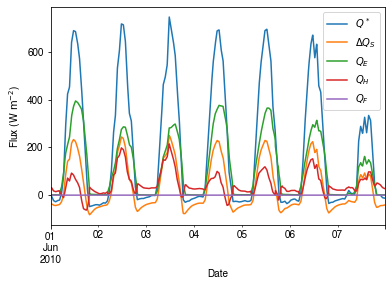

In [33]:
ax_output = df_output_suews\
    .loc['2010-06-01':'2010-06-07',
         ['QN', 'QS', 'QE', 'QH', 'QF']]\
    .rename(columns=dict_var_disp)\
    .plot()
_ = ax_output.set_xlabel('Date')
_ = ax_output.set_ylabel('Flux ($ \mathrm{W \ m^{-2}}$)')
_ = ax_output.legend()

#### Plotting after resampling

The suggested runtime/simulation frequency of SUEWS is `300 s`, which usually results a large output and may be over-weighted for storage and analysis. 
Also, you may feel apparent slowdown in producing the above figure as a large amount of data were used for the plotting.
To slim down the result size for analysis and output, we can `resample` the default output very easily.

In [34]:
rsmp_1d = df_output_suews.resample('1d')
# daily mean values
df_1d_mean = rsmp_1d.mean()
# daily sum values
df_1d_sum = rsmp_1d.sum()

We can then re-examine the above energy balance at hourly scale and plotting will be significantly faster.

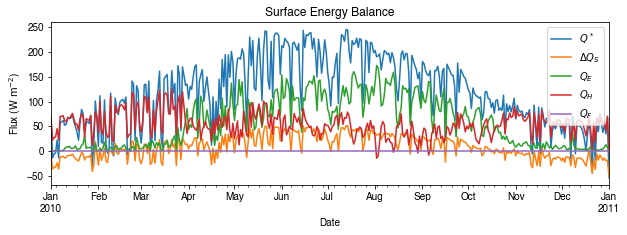

In [35]:
# energy balance
ax_output = df_1d_mean\
    .loc[:, ['QN', 'QS', 'QE', 'QH', 'QF']]\
    .rename(columns=dict_var_disp)\
    .plot(
            figsize=(10, 3),
            title='Surface Energy Balance',
        )
_ = ax_output.set_xlabel('Date')
_ = ax_output.set_ylabel('Flux ($ \mathrm{W \ m^{-2}}$)')
_ = ax_output.legend()

Then we use the hourly results for other analyses.

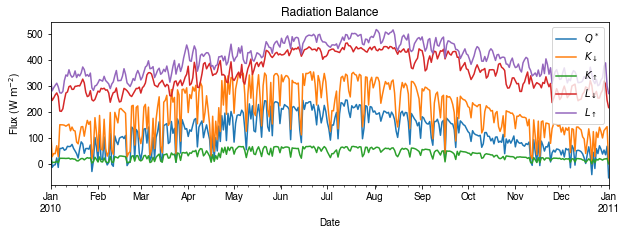

In [36]:
# radiation balance
ax_output = df_1d_mean\
    .loc[:, ['QN', 'Kdown', 'Kup', 'Ldown', 'Lup']]\
    .rename(columns=dict_var_disp)\
    .plot(
        figsize=(10, 3),
        title='Radiation Balance',
    )
_ = ax_output.set_xlabel('Date')
_ = ax_output.set_ylabel('Flux ($ \mathrm{W \ m^{-2}}$)')
_ = ax_output.legend()

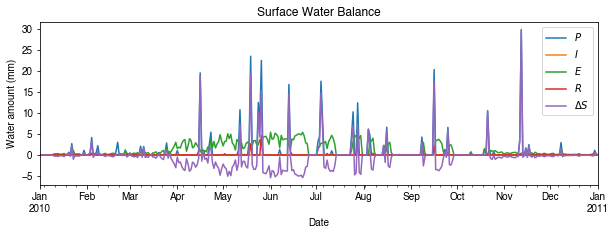

In [37]:
# water balance
ax_output = df_1d_sum\
    .loc[:, ['Rain', 'Irr', 'Evap', 'RO', 'TotCh']]\
    .rename(columns=dict_var_disp)\
    .plot(
        figsize=(10, 3),
        title='Surface Water Balance',
    )
_ = ax_output.set_xlabel('Date')
_ = ax_output.set_ylabel('Water amount (mm)')
_ = ax_output.legend()

Get an overview of partitioning in energy and water balance at monthly scales:

In [38]:
# get a monthly Resampler
df_plot = df_output_suews.copy()
df_plot.index = df_plot.index.set_names('Month')
rsmp_1M = df_plot\
    .shift(-1)\
    .dropna(how='all')\
    .resample('1M', kind='period')
# mean values
df_1M_mean = rsmp_1M.mean()
# sum values
df_1M_sum = rsmp_1M.sum()

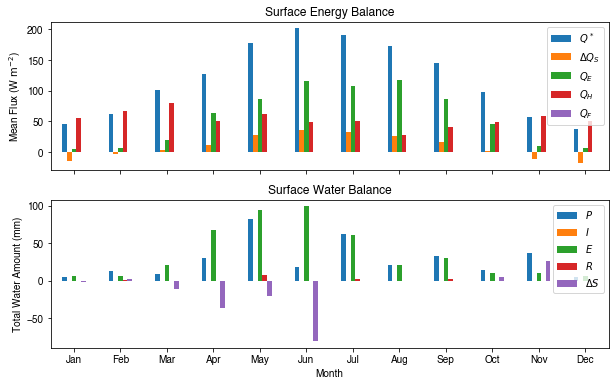

In [39]:
# month names
name_mon = [x.strftime('%b') for x in rsmp_1M.groups]
# create subplots showing two panels together
fig, axes = plt.subplots(2, 1, sharex=True)
# surface energy balance
_=df_1M_mean\
    .loc[:, ['QN', 'QS', 'QE', 'QH', 'QF']]\
    .rename(columns=dict_var_disp)\
    .plot(
        ax=axes[0],  # specify the axis for plotting
        figsize=(10, 6),  # specify figure size
        title='Surface Energy Balance',
        kind='bar',
    )
# surface water balance
_=df_1M_sum\
    .loc[:, ['Rain', 'Irr', 'Evap', 'RO', 'TotCh']]\
    .rename(columns=dict_var_disp)\
    .plot(
        ax=axes[1],  # specify the axis for plotting
        title='Surface Water Balance',
        kind='bar'
    )

# annotations
_ = axes[0].set_ylabel('Mean Flux ($ \mathrm{W \ m^{-2}}$)')
_ = axes[0].legend()
_ = axes[1].set_xlabel('Month')
_ = axes[1].set_ylabel('Total Water Amount (mm)')
_ = axes[1].xaxis.set_ticklabels(name_mon, rotation=0)
_ = axes[1].legend()

### Save results to external files

The supy output can be saved as `txt` files for further analysis using supy function `save_supy`.

In [40]:
list_path_save = sp.save_supy(df_output, df_state_final)

In [41]:
for file_out in list_path_save:
    print(file_out.name)

98_2010_SUEWS_5.txt
98_2010_snow_5.txt
98_2010_RSL_5.txt
98_2010_DailyState.txt
98_2010_SUEWS_60.txt
98_2010_snow_60.txt
98_2010_RSL_60.txt
df_state.csv


## More explorations into simulation results

In this section, we will use the simulation results to explore more features revealed by SuPy/SUEWS simulations but *unavailable in your simple model*.

### Dynamics in rainfall and soil moisture deficit (SMD)

In [42]:
df_dailystate = df_output.loc[grid, 'DailyState'].dropna(
    how='all').resample('1d').mean()

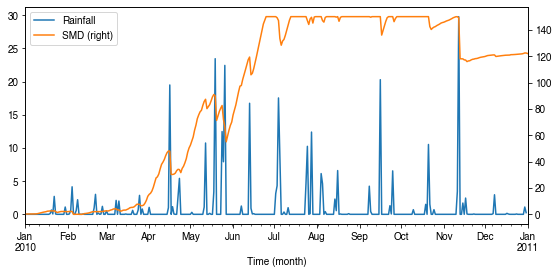

In [43]:
# daily rainfall
ser_p = df_dailystate.P_day.rename('Rainfall')
ser_smd = df_output_suews.SMD
ser_smd_dmax = ser_smd.resample('1d').max().rename('SMD')

ax = pd.concat([ser_p, ser_smd_dmax], axis=1).plot(secondary_y='SMD',
                                                   figsize=(9, 4))
_ = ax.set_xlabel('Time (month)')

### Variability in albedo

#### How does albedo change over time? 

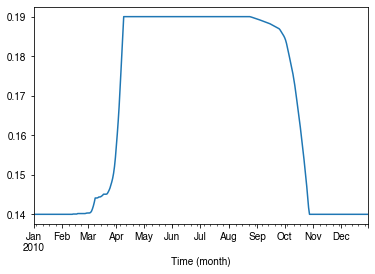

In [44]:
ser_alb = df_dailystate.AlbGrass
ax = ser_alb.plot()
_ = ax.set_xlabel('Time (month)')

#### How is albedo associated with vegetation phenology?

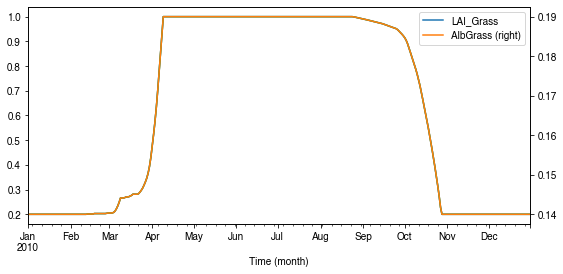

In [45]:
ser_lai = df_dailystate.LAI_Grass
pd.concat([ser_lai, ser_alb], axis=1).plot(secondary_y='AlbGrass',
                                           figsize=(9, 4))
ax = ser_lai.plot()
_ = ax.set_xlabel('Time (month)')

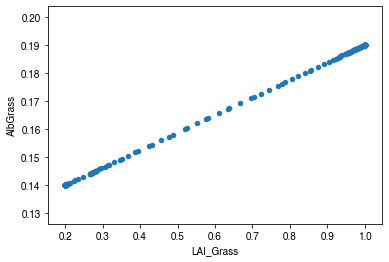

In [46]:
ax_alb_lai = df_dailystate[['LAI_Grass', 'AlbGrass']].plot.scatter(
    x='LAI_Grass',
    y='AlbGrass',
)
ax_alb_lai.set_aspect('auto')

### Variability in surface resistance

#### How does surface resistance vary over time?

In [47]:
ser_rs = df_output_suews.RS

- intra-annual 

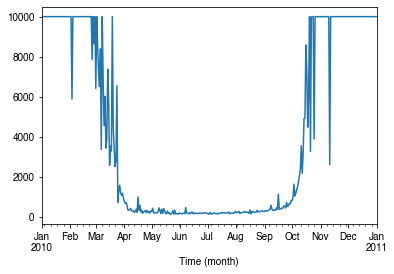

In [48]:
ax = ser_rs.resample('1d').median().plot()
_ = ax.set_xlabel('Time (month)')

- intra-daily

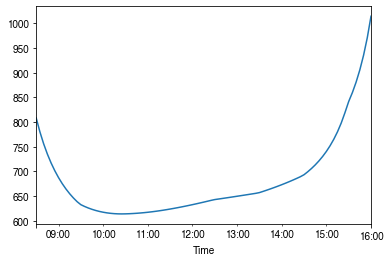

In [49]:
# a winter day
ax = ser_rs.loc['2010-01-22'].between_time('0830', '1600').plot()
_ = ax.set_xlabel('Time')

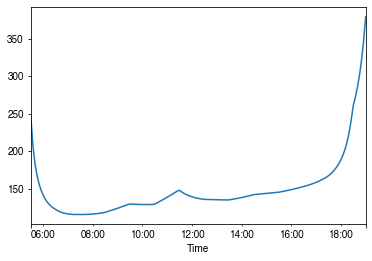

In [50]:
# a summer day
ax = ser_rs.loc['2010-07-01'].between_time('0530', '1900').plot()
_ = ax.set_xlabel('Time')

#### How is surface resistance associated with other surface properties?

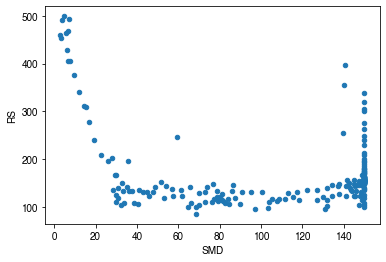

In [51]:
# SMD
ser_smd = df_output_suews.SMD
df_x = pd.concat([ser_smd, ser_rs],
                 axis=1).between_time('1000', '1600').resample('1d').mean()
df_x = df_x.loc[df_x.RS < 500]
_ = df_x.plot.scatter(
    x='SMD',
    y='RS',
)

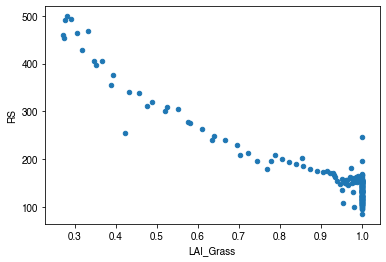

In [52]:
# LAI
df_x = pd.concat(
    [ser_lai,
     ser_rs.between_time('1000', '1600').resample('1d').mean()],
    axis=1)
df_x = df_x.loc[df_x.RS < 500]
_ = df_x.plot.scatter(
    x='LAI_Grass',
    y='RS',
)

#### How is surface resistance dependent on meteorological conditions?

In [53]:
cmap_sel = plt.cm.get_cmap('RdBu', 12)

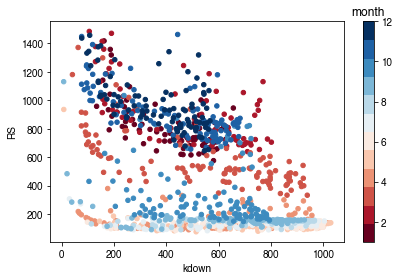

In [54]:
# solar radiation
# colour by season
ser_kdown = df_forcing_amf.kdown
df_x = pd.concat([ser_kdown, ser_rs], axis=1).between_time('1000', '1600')
df_x = df_x.loc[df_x.RS < 1500]
df_plot = df_x.iloc[::20]
ax = df_plot.plot.scatter(x='kdown',
                          y='RS',
                          c=df_plot.index.month,
                          cmap=cmap_sel,
                          sharex=False)
fig = ax.figure
_ = fig.axes[1].set_title('month')
fig.tight_layout()

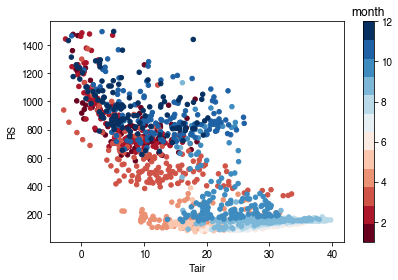

In [55]:
# air temperature
ser_ta = df_forcing_amf.Tair
df_x = pd.concat([ser_ta, ser_rs], axis=1).between_time('1000', '1600')
df_x = df_x.loc[df_x.RS < 1500]
df_plot = df_x.iloc[::15]
ax = df_plot.plot.scatter(x='Tair',
                          y='RS',
                          c=df_plot.index.month,
                          cmap=cmap_sel,
                          sharex=False)
fig = ax.figure
_ = fig.axes[1].set_title('month')
fig.tight_layout()

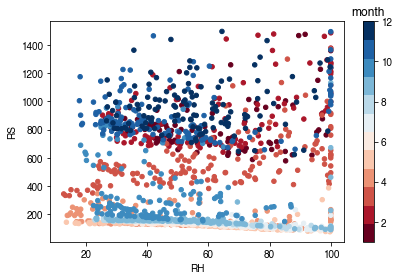

In [56]:
# air humidity
ser_rh = df_forcing_amf.RH
df_x = pd.concat([ser_rh, ser_rs], axis=1).between_time('1000', '1600')
df_x = df_x.loc[df_x.RS < 1500]
df_plot = df_x.iloc[::15]
ax = df_plot.plot.scatter(x='RH',
                          y='RS',
                          c=df_plot.index.month,
                          cmap=cmap_sel,
                          sharex=False)
fig = ax.figure
_ = fig.axes[1].set_title('month')
fig.tight_layout()

- **Task:**

Based on the above plots showing `RS` vs. met. conditions, explore these relationships again at the intra-daily scales.